In [1]:
#dependencies and setup
import matplotlib.pyplot as plt 
from matplotlib.pylab import rcParams
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
import seaborn as sns
sns.set(style='ticks',font='Arial',font_scale=1.2)
rcParams['figure.figsize'] = 12,8
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False

import requests
import json
from pprint import pprint

from wordcloud import WordCloud

#import spotify keys
from config import client_id
from config import client_secret

In [2]:
#from: https://stmorse.github.io/journal/spotify-api.html

AUTH_URL = 'https://accounts.spotify.com/api/token'

# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': client_id,
    'client_secret': client_secret,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']

In [3]:
#from: https://stmorse.github.io/journal/spotify-api.html

#base URL for Spotify API
base_url = 'https://api.spotify.com/v1/'

#In order to access, we send a properly formed GET request to the API server, with our access_token in the header. Let’s save this header info now, in the following very specific format:
headers = {
    'Authorization': 'Bearer {token}'.format(token=access_token)
}

In [4]:
#import global top songs csv
global_songs_df = pd.read_csv("resources/global-weekly-2022-06-02.csv")

#extracting track id (removing "spotify:track:")
track_id_series = global_songs_df.uri.str[14:]

#convert to df and rename column
track_id_df = track_id_series.to_frame().rename(columns={"uri":"track_id"})

#merge dfs
cleaned_global_df = global_songs_df.merge(track_id_df, how="inner", left_index=True, right_index=True)

#pare down columns
cleaned_global_df = cleaned_global_df[["rank", "track_id", "artist_names", "track_name", "peak_rank", "previous_rank", "weeks_on_chart", "streams"]]
cleaned_global_df.head()

,rank,track_id,artist_names,track_name,peak_rank,previous_rank,weeks_on_chart,streams
0,1,4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,1,1,9,60420855
1,2,6Sq7ltF9Qa7SNFBsV5Cogx,"Bad Bunny, Chencho Corleone",Me Porto Bonito,2,4,4,39026161
2,3,3k3NWokhRRkEPhCzPmV8TW,"Bad Bunny, Bomba Estéreo",Ojitos Lindos,3,3,4,37623538
3,4,75FEaRjZTKLhTrFGsfMUXR,Kate Bush,Running Up That Hill (A Deal With God) - 2018 ...,4,-1,1,32763806
4,5,1IHWl5LamUGEuP4ozKQSXZ,Bad Bunny,Tití Me Preguntó,5,9,4,31126704


In [5]:
#empty lists to store song data
danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
id_num = []
track_href = []
analysis_url = []
duration_mins = []
time_signature = []

for t in cleaned_global_df["track_id"]:
    response = requests.get(base_url + 'audio-features/' + t, headers=headers).json()
    
    #fill in track info for each audio feature / empty list
    danceability.append(response["danceability"])
    energy.append(response["energy"])
    key.append(response["key"])
    loudness.append(response["loudness"])
    mode.append(response["mode"])
    speechiness.append(response["speechiness"])
    acousticness.append(response["acousticness"])
    instrumentalness.append(response["instrumentalness"])
    liveness.append(response["liveness"])
    valence.append(response["valence"])
    tempo.append(response["tempo"])
    id_num.append(response["id"])
    track_href.append(response["track_href"])
    analysis_url.append(response["analysis_url"])    
    #duration recorded in api in milliseconds, converting to minutes here
    duration_mins.append(round((response["duration_ms"] / 60000),2))
    time_signature.append(response["time_signature"])    

In [6]:
songs_dict = {
    "track_id": id_num,
    "danceability": danceability,
    "energy": energy,
    "key": key,
    "loudness": loudness,
    "mode": mode,
    "speechiness": speechiness,
    "acousticness": acousticness,
    "instrumentalness": instrumentalness,
    "liveness": liveness,
    "valence": valence,
    "tempo": tempo,
    "duration_mins": duration_mins,
    "time_signature": time_signature,
    "track_href": track_href,
    "analysis_url": analysis_url
    
}

song_info_df = pd.DataFrame(songs_dict)
song_info_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,time_signature,track_href,analysis_url
0,4Dvkj6JhhA12EX05fT7y2e,0.520,0.731,6,-5.338,0,0.0557,0.3420,0.001010,0.3110,0.662,173.930,2.79,4,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...
1,6Sq7ltF9Qa7SNFBsV5Cogx,0.911,0.712,1,-5.105,0,0.0817,0.0901,0.000027,0.0933,0.425,92.005,2.98,4,https://api.spotify.com/v1/tracks/6Sq7ltF9Qa7S...,https://api.spotify.com/v1/audio-analysis/6Sq7...
2,3k3NWokhRRkEPhCzPmV8TW,0.647,0.686,3,-5.745,0,0.0413,0.0800,0.000001,0.5280,0.268,79.928,4.30,4,https://api.spotify.com/v1/tracks/3k3NWokhRRkE...,https://api.spotify.com/v1/audio-analysis/3k3N...
3,75FEaRjZTKLhTrFGsfMUXR,0.629,0.547,10,-13.123,0,0.0550,0.7200,0.003140,0.0604,0.197,108.375,4.98,4,https://api.spotify.com/v1/tracks/75FEaRjZTKLh...,https://api.spotify.com/v1/audio-analysis/75FE...
4,1IHWl5LamUGEuP4ozKQSXZ,0.650,0.715,5,-5.198,0,0.2530,0.0993,0.000291,0.1260,0.187,106.672,4.06,4,https://api.spotify.com/v1/tracks/1IHWl5LamUGE...,https://api.spotify.com/v1/audio-analysis/1IHW...


In [7]:
song_info_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,time_signature
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.677420,0.660955,5.700000,-6.028130,0.575000,0.093848,0.240392,0.008444,0.163475,0.515473,122.764030,3.433500,3.930000
std,0.145284,0.148103,3.741657,2.148431,0.495584,0.087021,0.251808,0.055802,0.125716,0.232828,29.751379,0.679784,0.274731
min,0.315000,0.202000,0.000000,-16.169000,0.000000,0.023200,0.000035,0.000000,0.027200,0.039200,71.105000,2.000000,3.000000
25%,0.578500,0.576500,2.000000,-7.111250,0.000000,0.040000,0.037075,0.000000,0.090875,0.337750,100.006000,2.910000,4.000000
50%,0.695000,0.685000,6.000000,-5.589000,1.000000,0.055400,0.141000,0.000002,0.115000,0.494500,117.947000,3.375000,4.000000
75%,0.795000,0.767250,9.000000,-4.526250,1.000000,0.099975,0.354500,0.000101,0.172500,0.688000,140.120750,3.852500,4.000000
max,0.949000,0.962000,11.000000,-2.278000,1.000000,0.404000,0.935000,0.633000,0.666000,0.969000,196.120000,5.910000,5.000000


In [8]:
full_track_data = cleaned_global_df.merge(song_info_df, how='inner', on="track_id")

In [9]:
#full_track_data["chart"] = "Global"
full_track_data.head()

,rank,track_id,artist_names,track_name,peak_rank,previous_rank,weeks_on_chart,streams,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,time_signature,track_href,analysis_url
0,1,4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,1,1,9,60420855,0.520,0.731,...,0.0557,0.3420,0.001010,0.3110,0.662,173.930,2.79,4,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...
1,2,6Sq7ltF9Qa7SNFBsV5Cogx,"Bad Bunny, Chencho Corleone",Me Porto Bonito,2,4,4,39026161,0.911,0.712,...,0.0817,0.0901,0.000027,0.0933,0.425,92.005,2.98,4,https://api.spotify.com/v1/tracks/6Sq7ltF9Qa7S...,https://api.spotify.com/v1/audio-analysis/6Sq7...
2,3,3k3NWokhRRkEPhCzPmV8TW,"Bad Bunny, Bomba Estéreo",Ojitos Lindos,3,3,4,37623538,0.647,0.686,...,0.0413,0.0800,0.000001,0.5280,0.268,79.928,4.30,4,https://api.spotify.com/v1/tracks/3k3NWokhRRkE...,https://api.spotify.com/v1/audio-analysis/3k3N...
3,4,75FEaRjZTKLhTrFGsfMUXR,Kate Bush,Running Up That Hill (A Deal With God) - 2018 ...,4,-1,1,32763806,0.629,0.547,...,0.0550,0.7200,0.003140,0.0604,0.197,108.375,4.98,4,https://api.spotify.com/v1/tracks/75FEaRjZTKLh...,https://api.spotify.com/v1/audio-analysis/75FE...
4,5,1IHWl5LamUGEuP4ozKQSXZ,Bad Bunny,Tití Me Preguntó,5,9,4,31126704,0.650,0.715,...,0.2530,0.0993,0.000291,0.1260,0.187,106.672,4.06,4,https://api.spotify.com/v1/tracks/1IHWl5LamUGE...,https://api.spotify.com/v1/audio-analysis/1IHW...


In [10]:
artist_id = []
genres = []

#grab artist id for each song - need for finding related genres
for t in full_track_data["track_id"]:
    artists_response = requests.get(base_url + 'tracks/' + t, headers=headers).json()
    artist_id.append(artists_response["artists"][0]["id"])

In [11]:
#add artist id to df
full_track_data["artist_id"] = artist_id
#full_track_data

In [12]:
#find genres related to each track (based on artist)
for i in full_track_data["artist_id"]:
    genres_response = requests.get(base_url + 'artists/' + i, headers=headers).json()
    genres.append(genres_response["genres"])

In [13]:
#add genres to df
full_track_data["genres"] = genres
#full_track_data

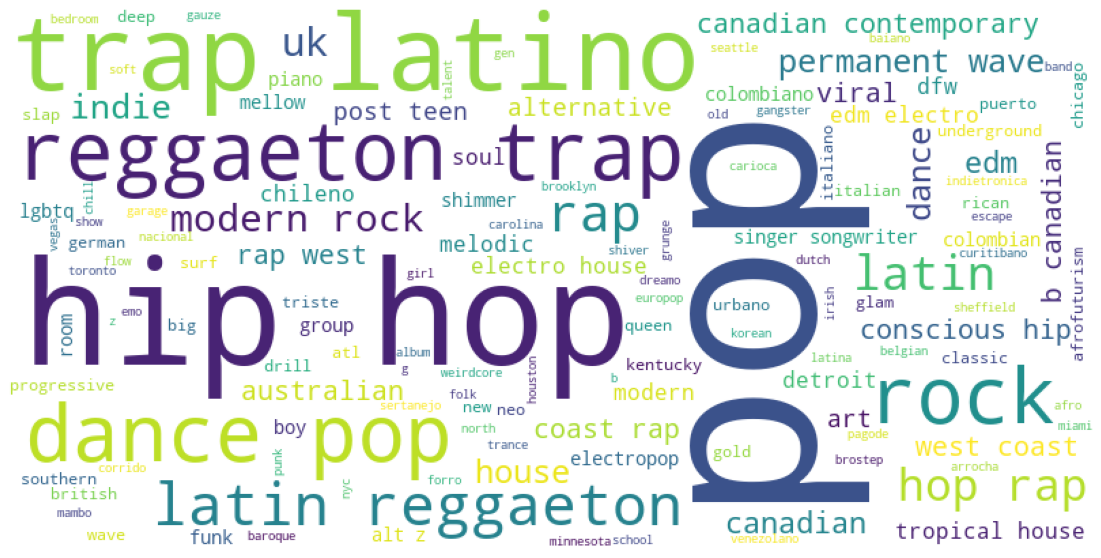

In [14]:
#found code via: https://www.kaggle.com/code/mchirico/quick-look-seaborn-wordcloud/notebook
#and https://stackoverflow.com/questions/69421276/wordcloud-with-text-from-a-column-with-list-of-strings

# Read the whole text.
text_col = full_track_data["genres"]
text = ' '.join(full_track_data['genres'].sum())

# Generate a word cloud image
#wordcloud = WordCloud().generate(text)

# take relative word frequencies into account
wordcloud = WordCloud(width=800, height=400, background_color="white",max_words=len(text_col),relative_scaling=.5).generate(text)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("images/genres_wordcloud.png",dpi=400)
plt.show()

In [15]:
#try binning song duration before making a bar chart
#min song length was 2.00 min, max was 5.91
bins = [1.99, 2.5, 2.99, 3.5, 3.99, 4.5, 4.99, 5.5, 5.99]
duration_labels = ["2.0 - 2.49 min", "2.5 - 2.99 min", "3.0 - 3.49 min", "3.5 - 3.99 min", "4.0 - 4.49 min", "4.5 - 4.99 min", "5.0 - 5.49 min", "5.5 - 5.99 min"]

full_track_data["duration_bins"] = pd.cut(full_track_data["duration_mins"], bins, labels=duration_labels)
full_track_data.head()

,rank,track_id,artist_names,track_name,peak_rank,previous_rank,weeks_on_chart,streams,danceability,energy,...,liveness,valence,tempo,duration_mins,time_signature,track_href,analysis_url,artist_id,genres,duration_bins
0,1,4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,1,1,9,60420855,0.520,0.731,...,0.3110,0.662,173.930,2.79,4,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...,6KImCVD70vtIoJWnq6nGn3,[pop],2.5 - 2.99 min
1,2,6Sq7ltF9Qa7SNFBsV5Cogx,"Bad Bunny, Chencho Corleone",Me Porto Bonito,2,4,4,39026161,0.911,0.712,...,0.0933,0.425,92.005,2.98,4,https://api.spotify.com/v1/tracks/6Sq7ltF9Qa7S...,https://api.spotify.com/v1/audio-analysis/6Sq7...,4q3ewBCX7sLwd24euuV69X,"[latin, reggaeton, trap latino]",2.5 - 2.99 min
2,3,3k3NWokhRRkEPhCzPmV8TW,"Bad Bunny, Bomba Estéreo",Ojitos Lindos,3,3,4,37623538,0.647,0.686,...,0.5280,0.268,79.928,4.30,4,https://api.spotify.com/v1/tracks/3k3NWokhRRkE...,https://api.spotify.com/v1/audio-analysis/3k3N...,4q3ewBCX7sLwd24euuV69X,"[latin, reggaeton, trap latino]",4.0 - 4.49 min
3,4,75FEaRjZTKLhTrFGsfMUXR,Kate Bush,Running Up That Hill (A Deal With God) - 2018 ...,4,-1,1,32763806,0.629,0.547,...,0.0604,0.197,108.375,4.98,4,https://api.spotify.com/v1/tracks/75FEaRjZTKLh...,https://api.spotify.com/v1/audio-analysis/75FE...,1aSxMhuvixZ8h9dK9jIDwL,"[art pop, art rock, baroque pop, new wave pop,...",4.5 - 4.99 min
4,5,1IHWl5LamUGEuP4ozKQSXZ,Bad Bunny,Tití Me Preguntó,5,9,4,31126704,0.650,0.715,...,0.1260,0.187,106.672,4.06,4,https://api.spotify.com/v1/tracks/1IHWl5LamUGE...,https://api.spotify.com/v1/audio-analysis/1IHW...,4q3ewBCX7sLwd24euuV69X,"[latin, reggaeton, trap latino]",4.0 - 4.49 min


In [16]:
duration_group = full_track_data.groupby("duration_bins").size()
duration_group = duration_group.to_frame(name="songs_count")
duration_group.reset_index(inplace=True)
duration_group

,duration_bins,songs_count
0,2.0 - 2.49 min,14
1,2.5 - 2.99 min,49
2,3.0 - 3.49 min,55
3,3.5 - 3.99 min,44
4,4.0 - 4.49 min,26
5,4.5 - 4.99 min,8
6,5.0 - 5.49 min,2
7,5.5 - 5.99 min,2


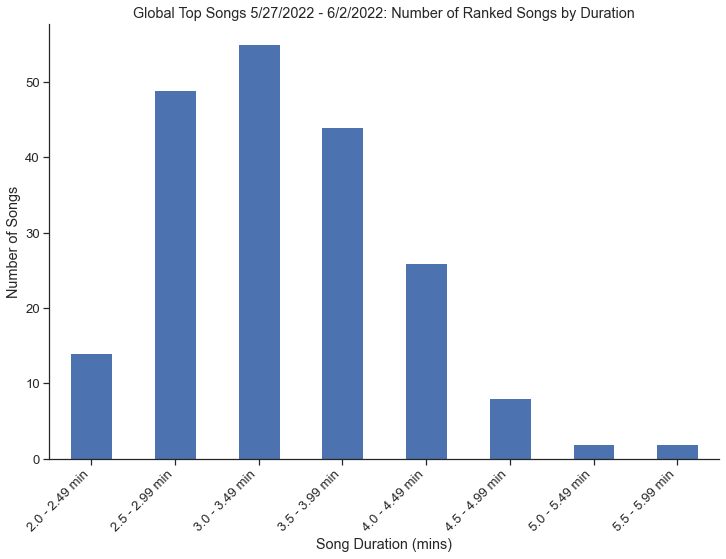

In [19]:
fig = duration_group.plot.bar("duration_bins",title="Global Top Songs 5/27/2022 - 6/2/2022: Number of Ranked Songs by Duration",xlabel="Song Duration (mins)",ylabel="Number of Songs", rot=45, legend=None)

plt.xticks(ha="right")


#save as png
plt.savefig("images/duration_bar.png",bbox_inches='tight')
plt.show()

In [20]:
duration_streams = full_track_data.groupby("duration_bins").agg({'streams':['sum']}) 
duration_streams

,streams
,sum
duration_bins,
2.0 - 2.49 min,135287531
2.5 - 2.99 min,546791060
3.0 - 3.49 min,549519200
3.5 - 3.99 min,449116396
4.0 - 4.49 min,282186824
4.5 - 4.99 min,86320015
5.0 - 5.49 min,12735014
5.5 - 5.99 min,17888593


In [21]:
#dataframe has two headers for column, this is dropping the top one
duration_streams.columns = duration_streams.columns.droplevel(0)
#renaming the column header that is left
duration_streams.rename(columns={"sum":"streams_sum"})

,streams_sum
duration_bins,
2.0 - 2.49 min,135287531
2.5 - 2.99 min,546791060
3.0 - 3.49 min,549519200
3.5 - 3.99 min,449116396
4.0 - 4.49 min,282186824
4.5 - 4.99 min,86320015
5.0 - 5.49 min,12735014
5.5 - 5.99 min,17888593


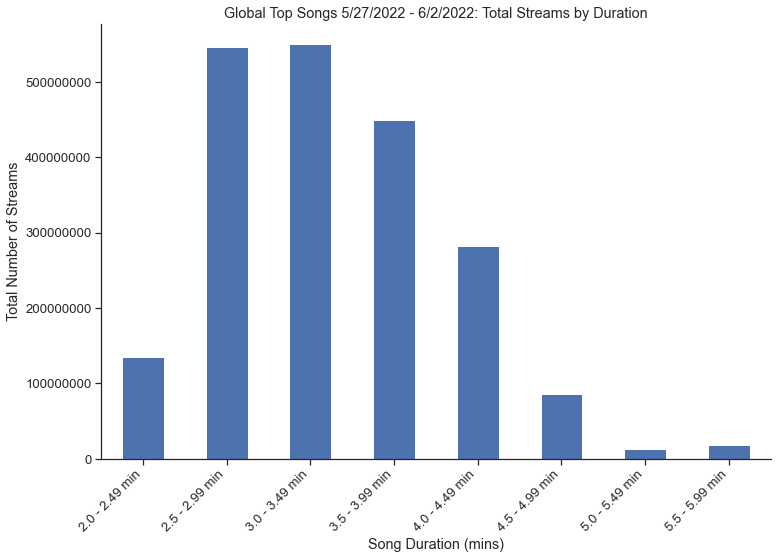

In [22]:
duration_streams.plot(kind='bar',title="Global Top Songs 5/27/2022 - 6/2/2022: Total Streams by Duration", xlabel="Song Duration (mins)", ylabel="Total Number of Streams", rot=45, legend=None)
plt.ticklabel_format(style='plain', axis='y')
plt.xticks(ha="right")
plt.savefig("images/duration_streams_bar.png",bbox_inches='tight')
plt.show()

The lower quartile of Song Duration is: 2.91
The upper quartile of Song Duration is: 3.85
The interquartile range of Song Duration is: 0.94
The median of Song Duration is: 3.375 
Values below 1.5 could be outliers.
Values above 5.26 could be outliers.


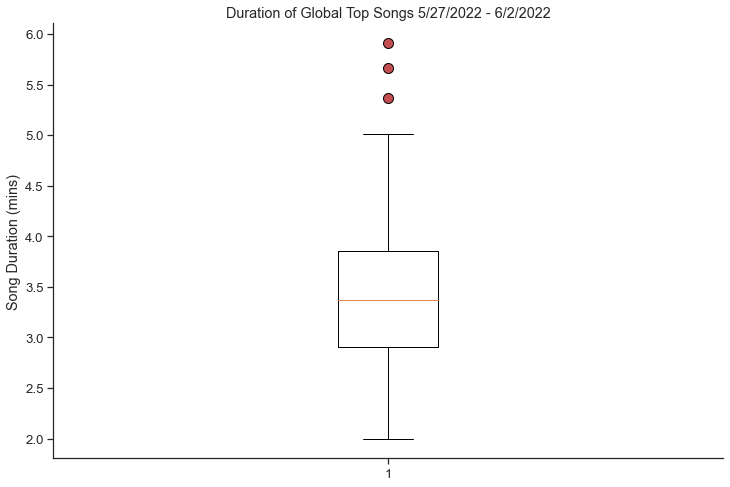

In [23]:
quartiles = full_track_data.duration_mins.quantile([.25,.5,.75])
lowerq = quartiles[0.25].round(2)
upperq = quartiles[0.75].round(2)
iqr = (upperq-lowerq).round(2)
lower_bound = (lowerq - (1.5*iqr)).round(2)
upper_bound = (upperq + (1.5*iqr)).round(2)
   
print(f"The lower quartile of Song Duration is: {lowerq}")
print(f"The upper quartile of Song Duration is: {upperq}")
print(f"The interquartile range of Song Duration is: {iqr}")
print(f"The median of Song Duration is: {quartiles[0.5]} ")
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

flierprops = dict(marker='o', markerfacecolor='r', markersize=10)
fig1, ax1 = plt.subplots()
ax1.set_title('Duration of Global Top Songs 5/27/2022 - 6/2/2022')
ax1.set_ylabel('Song Duration (mins)')
ax1.boxplot(full_track_data["duration_mins"], flierprops=flierprops)

#save as png
plt.savefig("images/duration_boxplot.png")
plt.show()

In [26]:
#look at outliers
duration_outliers_df = full_track_data.loc[full_track_data["duration_mins"] > 5.26]
duration_outliers_df[["rank","artist_names","track_name","weeks_on_chart","streams","duration_mins","duration_bins","genres"]]

,rank,artist_names,track_name,weeks_on_chart,streams,duration_mins,duration_bins,genres
57,58,"Bad Bunny, Buscabulla",Andrea,4,11362643,5.66,5.5 - 5.99 min,"[latin, reggaeton, trap latino]"
136,137,Queen,Bohemian Rhapsody - Remastered 2011,192,6525950,5.91,5.5 - 5.99 min,"[classic rock, glam rock, rock]"
148,149,Eminem,"Lose Yourself - From ""8 Mile"" Soundtrack",76,6302645,5.37,5.0 - 5.49 min,"[detroit hip hop, hip hop, rap]"


In [27]:
#try binning songs by ranking on chart
#min ranking is 1, max is 200
bins = [0, 50, 100, 150, 200]
rank_labels = ["1 to 50", "51 to 100", "101 to 150", "151 to 200"]

full_track_data["rank_bins"] = pd.cut(full_track_data["rank"], bins, labels=rank_labels)

In [28]:
avg_duration_rank_df = full_track_data.groupby('rank_bins')[['duration_mins']].mean()
avg_duration_rank_df.reset_index(inplace=True)
avg_duration_rank_df

,rank_bins,duration_mins
0,1 to 50,3.3044
1,51 to 100,3.5026
2,101 to 150,3.5900
3,151 to 200,3.3370


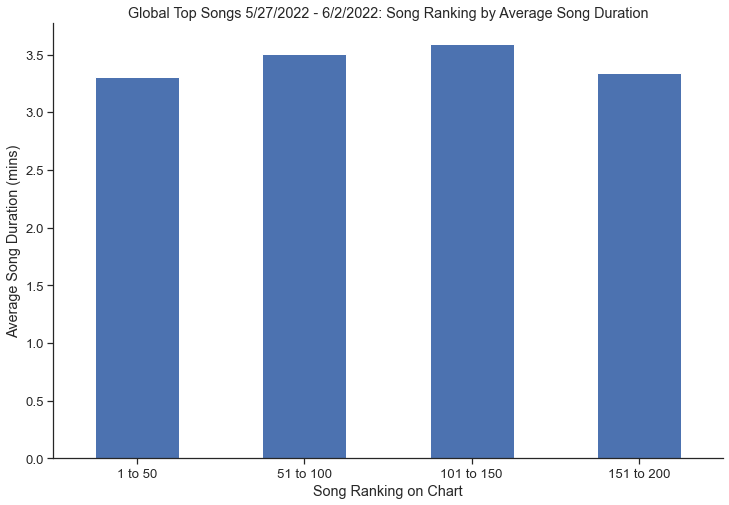

In [29]:
bins_fig = avg_duration_rank_df.plot(x='rank_bins', y='duration_mins', kind="bar", title="Global Top Songs 5/27/2022 - 6/2/2022: Song Ranking by Average Song Duration", rot=0, legend=None)
plt.xlabel("Song Ranking on Chart")
plt.ylabel("Average Song Duration (mins)")
plt.savefig("images/ranking_avg_duration.png",bbox_inches='tight')
plt.show()

The r value is: -0.010469514805883429
The r-squared is: 0.00010961074027061232


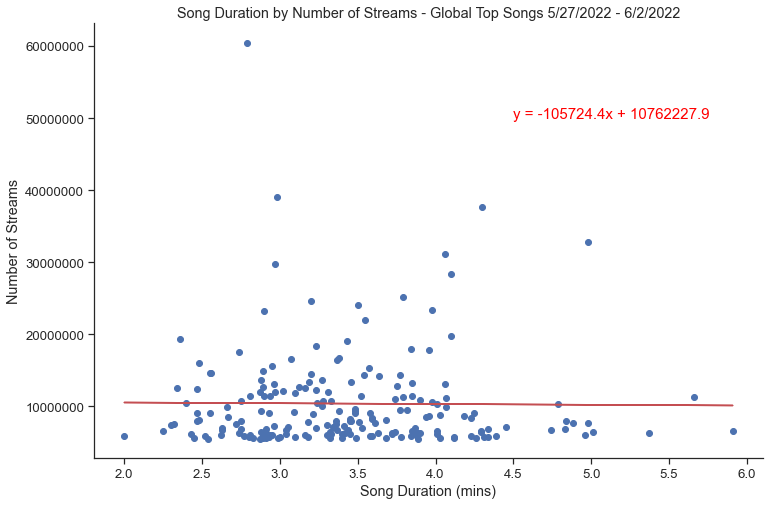

In [30]:
xvalues =full_track_data["duration_mins"]
yvalues = full_track_data["streams"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(xvalues, yvalues)
regress_values = xvalues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(xvalues, yvalues, c="b")
plt.plot(xvalues,regress_values,"r-")
#turn off scientific notation in axis
plt.ticklabel_format(style='plain')
# Set a Title and labels
plt.title("Song Duration by Number of Streams - Global Top Songs 5/27/2022 - 6/2/2022")
plt.xlabel("Song Duration (mins)")
plt.ylabel("Number of Streams")
#adding line equation to the scatter plot
plt.annotate(line_eq,(4.5,50000000),fontsize=15,color="red")
print(f"The r value is: {rvalue}")
print(f"The r-squared is: {rvalue**2}")

#save as png
plt.savefig("images/duration_streams.png")
plt.show()

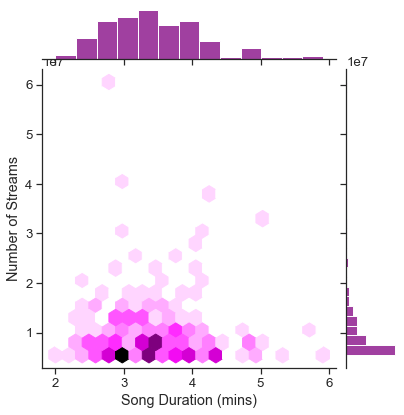

In [31]:
#experimenting with hexplot of streams and song length
xvalues =full_track_data["duration_mins"]
yvalues = full_track_data["streams"]

h = sns.jointplot(x=xvalues, y=yvalues, kind="hex", color="purple")
h.set_axis_labels('Song Duration (mins)', 'Number of Streams')

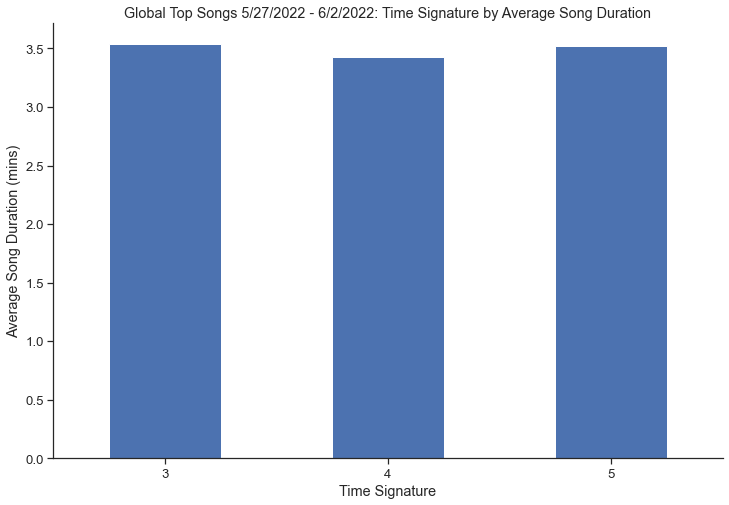

In [32]:
#Time Signature = An estimated time signature. The time signature (meter) is a notational convention to specify how many beats
#are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

#try grouping songs by time signature
#min is 3, max is 7

timesig_avgduration_df = full_track_data.groupby('time_signature')[['duration_mins']].mean()
timesig_avgduration_df.reset_index(inplace=True)
timesig_avgduration_df


timesig_fig = timesig_avgduration_df.plot(x='time_signature', y='duration_mins', kind="bar", title="Global Top Songs 5/27/2022 - 6/2/2022: Time Signature by Average Song Duration", rot=0, legend=None)
plt.xlabel("Time Signature")
plt.ylabel("Average Song Duration (mins)")

plt.show()

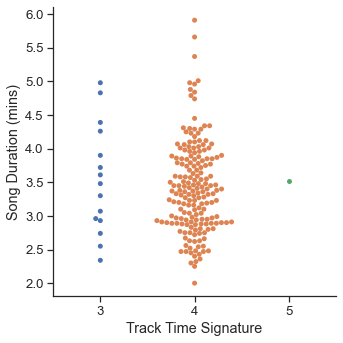

In [33]:
#experimenting with swarmplot - a categorical scatterplot with non-overlapping points (https://seaborn.pydata.org/generated/seaborn.swarmplot.html#seaborn.swarmplot)
sns.color_palette("colorblind")
p = sns.catplot(x="time_signature", y="duration_mins", kind="swarm", data=full_track_data)
p.set_axis_labels(x_var="Track Time Signature", y_var="Song Duration (mins)")

The r value is: -0.039580404862229156
The r-squared is: 0.0015666084490579735


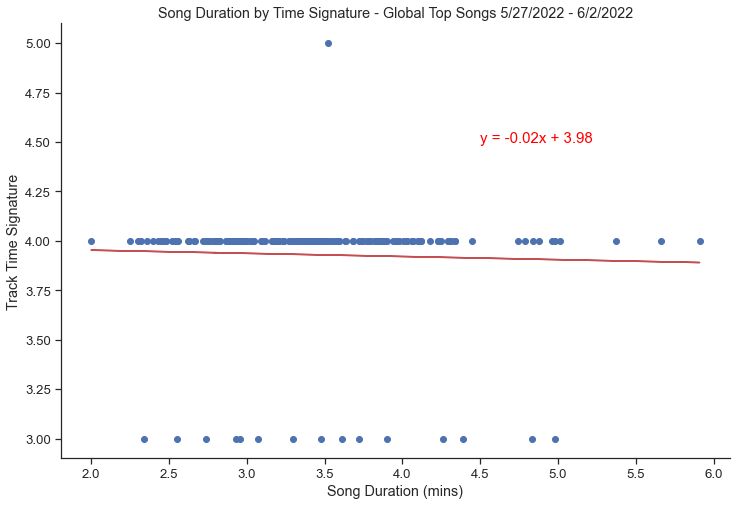

In [34]:
xvalues =full_track_data["duration_mins"]
yvalues = full_track_data["time_signature"]

#Time Signature = An estimated time signature. The time signature (meter) is a notational convention to specify how many beats
#are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4".

(slope, intercept, rvalue, pvalue, stderr) = linregress(xvalues, yvalues)
regress_values = xvalues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(xvalues, yvalues, c="b")
plt.plot(xvalues,regress_values,"r-")
# Set a Title and labels
plt.title("Song Duration by Time Signature - Global Top Songs 5/27/2022 - 6/2/2022")
plt.xlabel("Song Duration (mins)")
plt.ylabel("Track Time Signature")
#adding line equation to the scatter plot
plt.annotate(line_eq,(4.5,4.5),fontsize=15,color="red")
print(f"The r value is: {rvalue}")
print(f"The r-squared is: {rvalue**2}")

#save as png
plt.savefig("images/duration_timesig.png")
plt.show()

The r value is: -0.1514019648207119
The r-squared is: 0.02292255495157208


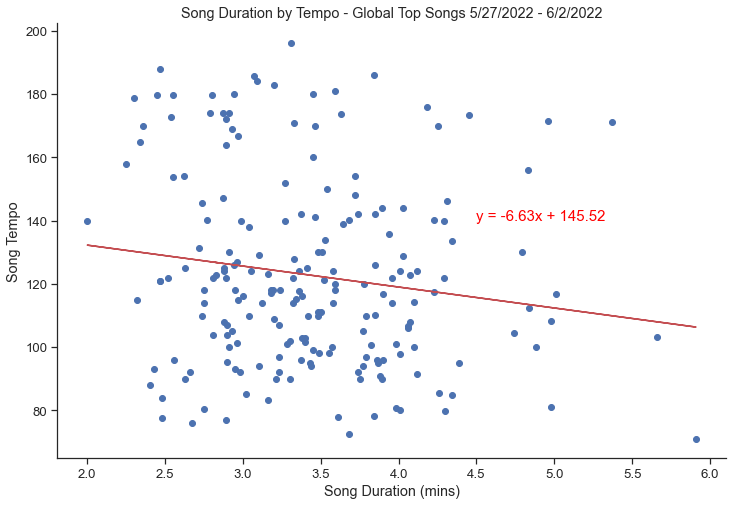

In [35]:
xvalues =full_track_data["duration_mins"]
yvalues = full_track_data["tempo"]

#Tempo = The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed 
#or pace of a given piece and derives directly from the average beat duration.

(slope, intercept, rvalue, pvalue, stderr) = linregress(xvalues, yvalues)
regress_values = xvalues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(xvalues, yvalues, c="b")
plt.plot(xvalues,regress_values,"r-")
#adding title and labels
plt.title("Song Duration by Tempo - Global Top Songs 5/27/2022 - 6/2/2022")
plt.xlabel("Song Duration (mins)")
plt.ylabel("Song Tempo")
#adding line equation to the scatter plot
plt.annotate(line_eq,(4.5,140),fontsize=15,color="red")
print(f"The r value is: {rvalue}")
print(f"The r-squared is: {rvalue**2}")

#save as png
plt.savefig("images/duration_tempo.png")
plt.show()

The r value is: -0.11635909402959758
The r-squared is: 0.013539438763388732


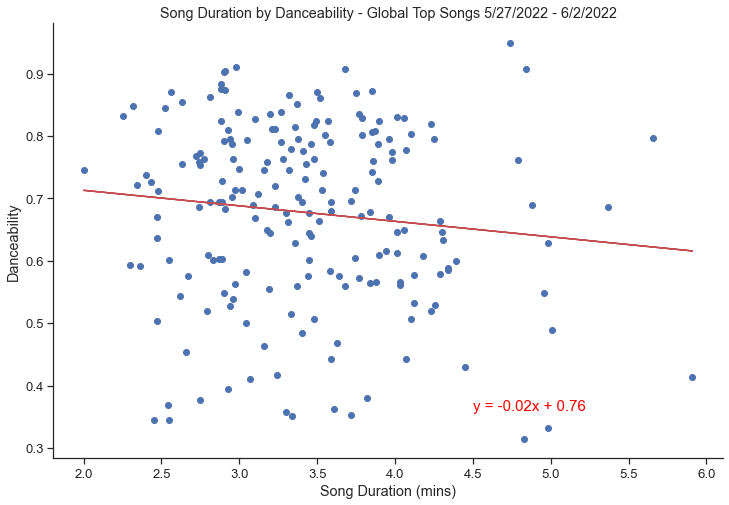

In [36]:
xvalues =full_track_data["duration_mins"]
yvalues = full_track_data["danceability"]

#Danceability = Danceability describes how suitable a track is for dancing based on a combination of musical elements 
#including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable 
#and 1.0 is most danceable.

(slope, intercept, rvalue, pvalue, stderr) = linregress(xvalues, yvalues)
regress_values = xvalues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(xvalues, yvalues, c="b")
plt.plot(xvalues,regress_values,"r-")
#adding title and labels
plt.title("Song Duration by Danceability - Global Top Songs 5/27/2022 - 6/2/2022")
plt.xlabel("Song Duration (mins)")
plt.ylabel("Danceability")
#adding line equation to the scatter plot
plt.annotate(line_eq,(4.5,.36),fontsize=15,color="red")
print(f"The r value is: {rvalue}")
print(f"The r-squared is: {rvalue**2}")

#save as png
plt.savefig("images/duration_danceability.png")
plt.show()

The r value is: -0.03387166649520214
The r-squared is: 0.001147289791162199


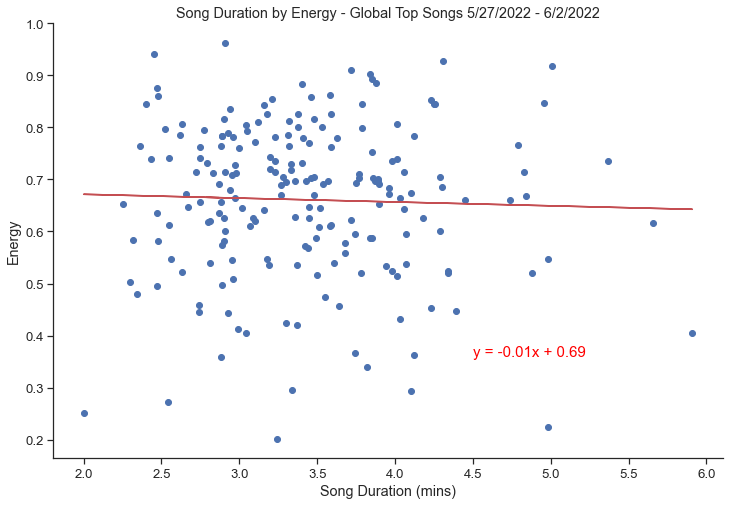

In [37]:
xvalues =full_track_data["duration_mins"]
yvalues = full_track_data["energy"]

#Energy = Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. 
#Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while 
#a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, 
#perceived loudness, timbre, onset rate, and general entropy.

(slope, intercept, rvalue, pvalue, stderr) = linregress(xvalues, yvalues)
regress_values = xvalues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(xvalues, yvalues, c="b")
plt.plot(xvalues,regress_values,"r-")
#adding title and labels
plt.title("Song Duration by Energy - Global Top Songs 5/27/2022 - 6/2/2022")
plt.xlabel("Song Duration (mins)")
plt.ylabel("Energy")
#adding line equation to the scatter plot
plt.annotate(line_eq,(4.5,.36),fontsize=15,color="red")
print(f"The r value is: {rvalue}")
print(f"The r-squared is: {rvalue**2}")

#save as png
plt.savefig("images/duration_energy.png")
plt.show()

The r value is: 0.15595840387460344
The r-squared is: 0.024323023739113922


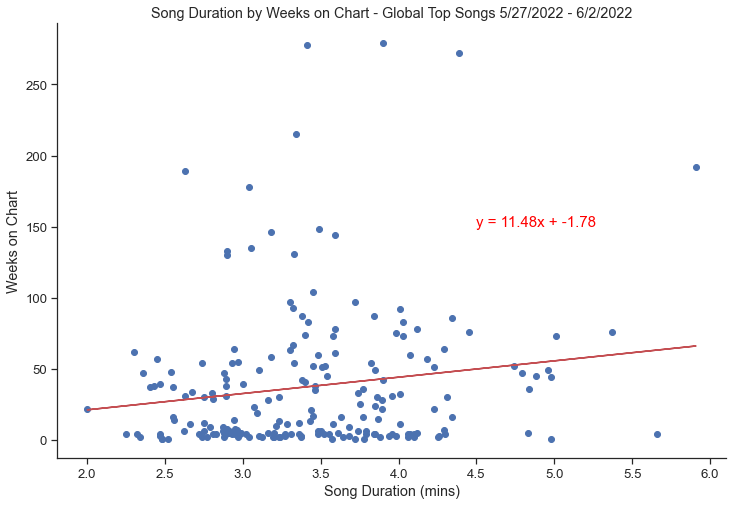

In [38]:
xvalues =full_track_data["duration_mins"]
yvalues = full_track_data["weeks_on_chart"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(xvalues, yvalues)
regress_values = xvalues * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(xvalues, yvalues, c="b")
plt.plot(xvalues,regress_values,"r-")
#adding title and labels
plt.title("Song Duration by Weeks on Chart - Global Top Songs 5/27/2022 - 6/2/2022")
plt.xlabel("Song Duration (mins)")
plt.ylabel("Weeks on Chart")
#adding line equation to the scatter plot
plt.annotate(line_eq,(4.5,150),fontsize=15,color="red")
print(f"The r value is: {rvalue}")
print(f"The r-squared is: {rvalue**2}")

#save as png
plt.savefig("images/duration_weeks-on-chart.png")
plt.show()

In [39]:
#repeating dataframe set up process and running with USA Chart

#import us top songs csv
us_songs_df = pd.read_csv("resources/usa-weekly-2022-06-02.csv")

#extracting track id (removing "spotify:track:")
track_id_series = us_songs_df.uri.str[14:]

#convert to df and rename column
track_id_df = track_id_series.to_frame().rename(columns={"uri":"track_id"})

#merge dfs
cleaned_us_df = us_songs_df.merge(track_id_df, how="inner", left_index=True, right_index=True)

#pare down columns
cleaned_us_df = cleaned_us_df[["rank", "track_id", "artist_names", "track_name", "peak_rank", "previous_rank", "weeks_on_chart", "streams"]]
#cleaned_us_df.head()

#empty lists to store song data
danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
id_num = []
track_href = []
analysis_url = []
duration_mins = []
time_signature = []

for t in cleaned_us_df["track_id"]:
    response = requests.get(base_url + 'audio-features/' + t, headers=headers).json()
    
    #fill in track info for each audio feature / empty list
    danceability.append(response["danceability"])
    energy.append(response["energy"])
    key.append(response["key"])
    loudness.append(response["loudness"])
    mode.append(response["mode"])
    speechiness.append(response["speechiness"])
    acousticness.append(response["acousticness"])
    instrumentalness.append(response["instrumentalness"])
    liveness.append(response["liveness"])
    valence.append(response["valence"])
    tempo.append(response["tempo"])
    id_num.append(response["id"])
    track_href.append(response["track_href"])
    analysis_url.append(response["analysis_url"])    
    #duration recorded in api in milliseconds, converting to minutes here
    duration_mins.append(round((response["duration_ms"] / 60000),2))
    time_signature.append(response["time_signature"])  

us_songs_dict = {
    "track_id": id_num,
    "danceability": danceability,
    "energy": energy,
    "key": key,
    "loudness": loudness,
    "mode": mode,
    "speechiness": speechiness,
    "acousticness": acousticness,
    "instrumentalness": instrumentalness,
    "liveness": liveness,
    "valence": valence,
    "tempo": tempo,
    "duration_mins": duration_mins,
    "time_signature": time_signature,
    "track_href": track_href,
    "analysis_url": analysis_url
    
}

us_song_info_df = pd.DataFrame(us_songs_dict)

us_track_data = cleaned_us_df.merge(us_song_info_df, how='inner', on="track_id")

#us_track_data["chart"] = "USA"
us_track_data = us_track_data.rename(columns={"rank":"us_rank", 
                                              "peak_rank":"us_peak_rank", 
                                              "previous_rank":"us_previous_rank", 
                                              "weeks_on_chart":"weeks_on_us_chart", 
                                              "streams":"us_streams"})

us_track_data

,us_rank,track_id,artist_names,track_name,us_peak_rank,us_previous_rank,weeks_on_us_chart,us_streams,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,time_signature,track_href,analysis_url
0,1,4Dvkj6JhhA12EX05fT7y2e,Harry Styles,As It Was,1,1,9,13694429,0.520,0.731,...,0.0557,0.3420,0.001010,0.3110,0.662,173.930,2.79,4,https://api.spotify.com/v1/tracks/4Dvkj6JhhA12...,https://api.spotify.com/v1/audio-analysis/4Dvk...
1,2,1qEmFfgcLObUfQm0j1W2CK,Harry Styles,Late Night Talking,2,2,2,9474291,0.714,0.728,...,0.0468,0.2980,0.000000,0.1060,0.901,114.996,2.97,4,https://api.spotify.com/v1/tracks/1qEmFfgcLObU...,https://api.spotify.com/v1/audio-analysis/1qEm...
2,3,75FEaRjZTKLhTrFGsfMUXR,Kate Bush,Running Up That Hill (A Deal With God) - 2018 ...,3,-1,1,9283126,0.629,0.547,...,0.0550,0.7200,0.003140,0.0604,0.197,108.375,4.98,4,https://api.spotify.com/v1/tracks/75FEaRjZTKLh...,https://api.spotify.com/v1/audio-analysis/75FE...
3,4,0wHFktze2PHC5jDt3B17DC,Jack Harlow,First Class,1,14,8,7668384,0.902,0.582,...,0.1090,0.1110,0.000003,0.1110,0.332,107.005,2.90,4,https://api.spotify.com/v1/tracks/0wHFktze2PHC...,https://api.spotify.com/v1/audio-analysis/0wHF...
4,5,6Sq7ltF9Qa7SNFBsV5Cogx,"Bad Bunny, Chencho Corleone",Me Porto Bonito,5,16,4,7526221,0.911,0.712,...,0.0817,0.0901,0.000027,0.0933,0.425,92.005,2.98,4,https://api.spotify.com/v1/tracks/6Sq7ltF9Qa7S...,https://api.spotify.com/v1/audio-analysis/6Sq7...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,7AQim7LbvFVZJE3O8TYgf2,"XXXTENTACION, Trippie Redd",Fuck Love (feat. Trippie Redd),8,-1,201,1653636,0.797,0.533,...,0.0412,0.0172,0.000152,0.1030,0.329,131.036,2.44,4,https://api.spotify.com/v1/tracks/7AQim7LbvFVZ...,https://api.spotify.com/v1/audio-analysis/7AQi...
196,197,07MDkzWARZaLEdKxo6yArG,"THE ANXIETY, WILLOW, Tyler Cole",Meet Me At Our Spot,10,190,41,1649081,0.773,0.470,...,0.0299,0.0153,0.000193,0.0851,0.399,94.995,2.71,4,https://api.spotify.com/v1/tracks/07MDkzWARZaL...,https://api.spotify.com/v1/audio-analysis/07MD...
197,198,2JvzF1RMd7lE3KmFlsyZD8,J. Cole,MIDDLE CHILD,1,-1,156,1635663,0.837,0.364,...,0.2760,0.1490,0.000000,0.2710,0.463,123.984,3.56,4,https://api.spotify.com/v1/tracks/2JvzF1RMd7lE...,https://api.spotify.com/v1/audio-analysis/2Jvz...
198,199,7fBv7CLKzipRk6EC6TWHOB,The Weeknd,The Hills,27,-1,69,1634590,0.585,0.564,...,0.0515,0.0671,0.000000,0.1350,0.137,113.003,4.04,4,https://api.spotify.com/v1/tracks/7fBv7CLKzipR...,https://api.spotify.com/v1/audio-analysis/7fBv...


In [40]:
bins = [1.99, 2.5, 2.99, 3.5, 3.99, 4.5, 4.99, 5.5, 5.99]
duration_labels = ["2.0 - 2.49 min", "2.5 - 2.99 min", "3.0 - 3.49 min", "3.5 - 3.99 min", "4.0 - 4.49 min", "4.5 - 4.99 min", "5.0 - 5.49 min", "5.5 - 5.99 min"]

us_track_data["duration_bins"] = pd.cut(us_track_data["duration_mins"], bins, labels=duration_labels)
#us_track_data.head()
us_duration_group = us_track_data.groupby("duration_bins").size()

us_duration_group = us_duration_group.to_frame(name="songs_count")
us_duration_group.reset_index(inplace=True)
us_duration_group

,duration_bins,songs_count
0,2.0 - 2.49 min,19
1,2.5 - 2.99 min,41
2,3.0 - 3.49 min,48
3,3.5 - 3.99 min,48
4,4.0 - 4.49 min,23
5,4.5 - 4.99 min,14
6,5.0 - 5.49 min,4
7,5.5 - 5.99 min,1


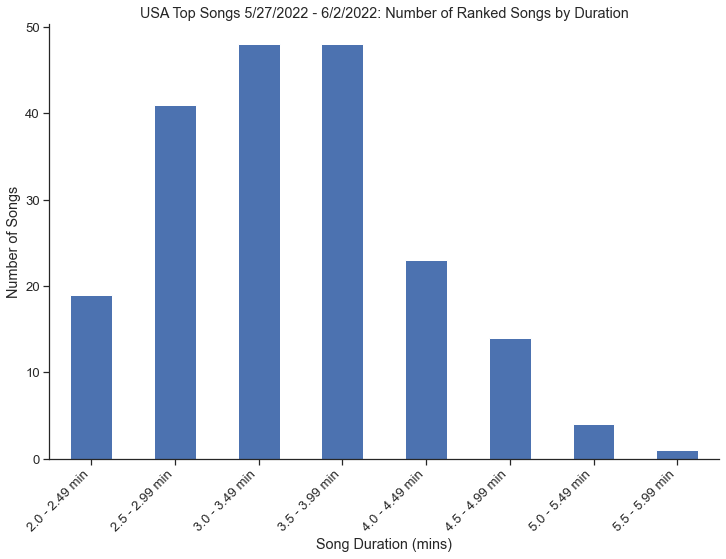

In [41]:
fig = us_duration_group.plot.bar("duration_bins",title="USA Top Songs 5/27/2022 - 6/2/2022: Number of Ranked Songs by Duration",xlabel="Song Duration (mins)",ylabel="Number of Songs", rot=45, legend=None)
plt.xticks(ha="right")

#save as png
plt.savefig("images/usa_duration_bar.png",bbox_inches='tight')
plt.show()

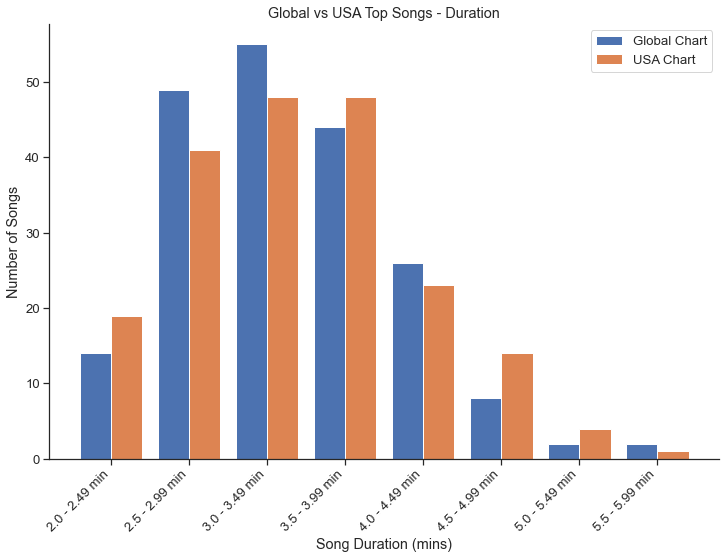

In [43]:
x = duration_labels
global_count = duration_group["songs_count"]
usa_count = us_duration_group["songs_count"]
  
x_axis = np.arange(len(x))
  
plt.bar(x_axis - 0.2, global_count, 0.4, label = 'Global Chart')
plt.bar(x_axis + 0.2, usa_count, 0.4, label = 'USA Chart')
  
plt.xticks(x_axis, x,rotation = 45, ha="right")
plt.xlabel("Song Duration (mins)")
plt.ylabel("Number of Songs")
plt.title("Global vs USA Top Songs - Duration")
plt.legend()
plt.savefig("images/usa_global_bar.png",bbox_inches='tight')
plt.show()